In [31]:
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt
from simulator_pa import pa_generator
import betti
import pandas as pd

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit



# Speed
- Run as scripts
- Compare graph generation time vs Betti # (numba may help)
- joblib to run in parallel

# Graphs
- CDF (Right to Left) 
- Plot all graphs on same plot
- Check if Log-Log CDF is roughly linear
- Fit line to Log-Log CDF

In [32]:
def emp_cdf(x):
    n = len(x)
    x_sort = np.sort(x)
    cdf = (np.arange(1, n + 1) - 0.5) / n
    cdf = cdf[::-1]
    return x_sort, cdf


N = 1000
def betti_nums(num_nodes, m, delta):
    betti_vals = np.zeros(N)
    for i in range(N):
        graph = pa_generator(num_nodes, m, delta, i)
        mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
        betti2_actual = betti.translate_PD_to_betti(dgms[2], num_nodes) # read the betti numbers from persistence diagrams
        betti_vals[i] = betti2_actual[-1]
        
#     mean = np.mean(betti_vals)
#     halfwidth = 1.96 * np.std(betti_vals) / np.sqrt(N)
#     CI = f'[{mean - halfwidth}, {mean + halfwidth}]'
#     data = {'Num Nodes' : num_nodes, 'm' : m, 'delta' : delta, 'CI' : CI}

    x, cdf = emp_cdf(betti_vals)
    return x, cdf



In [33]:
args = [(10000, 7, -5), (10000, 7, -1), (10000, 10, -8), (10000, 10, -4), (10000, 10, -1)]
x, cdf = zip(*Parallel(n_jobs=5)(delayed(betti_nums)(*arg) for arg in args))

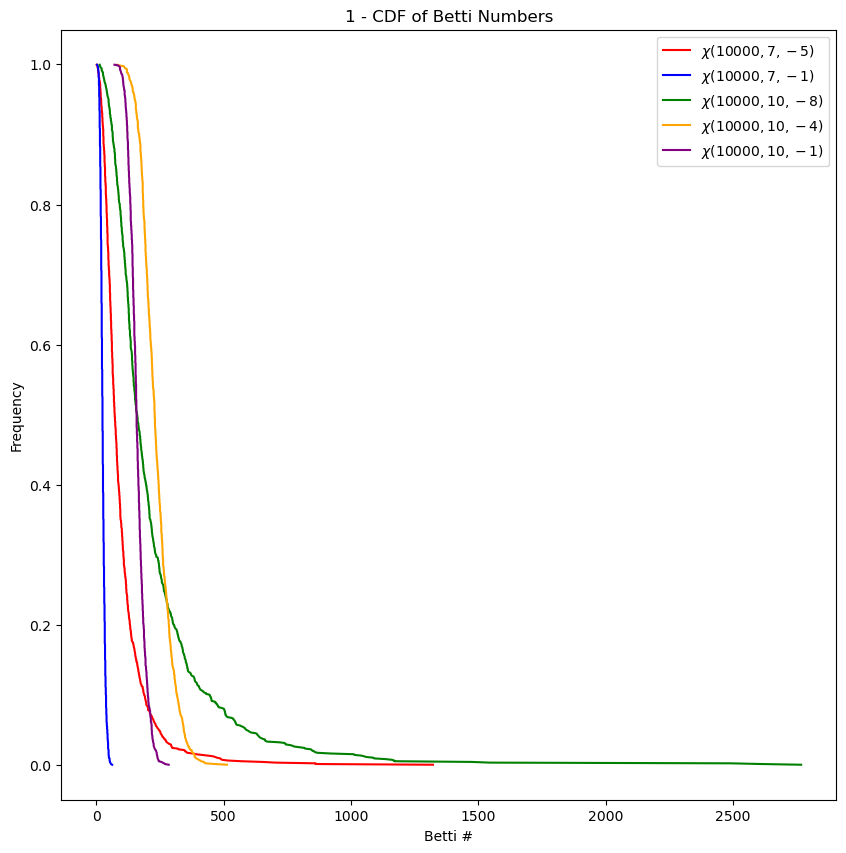

In [72]:
plt.figure(figsize=(10, 10))

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(len(x)):
    plt.plot(x[i], cdf[i], color = colors[i], label = f'$\chi{args[i]}$')

plt.xlabel('Betti #')
plt.ylabel('Frequency')
plt.legend()
plt.title(r'1 - CDF of Betti Numbers')
plt.show()

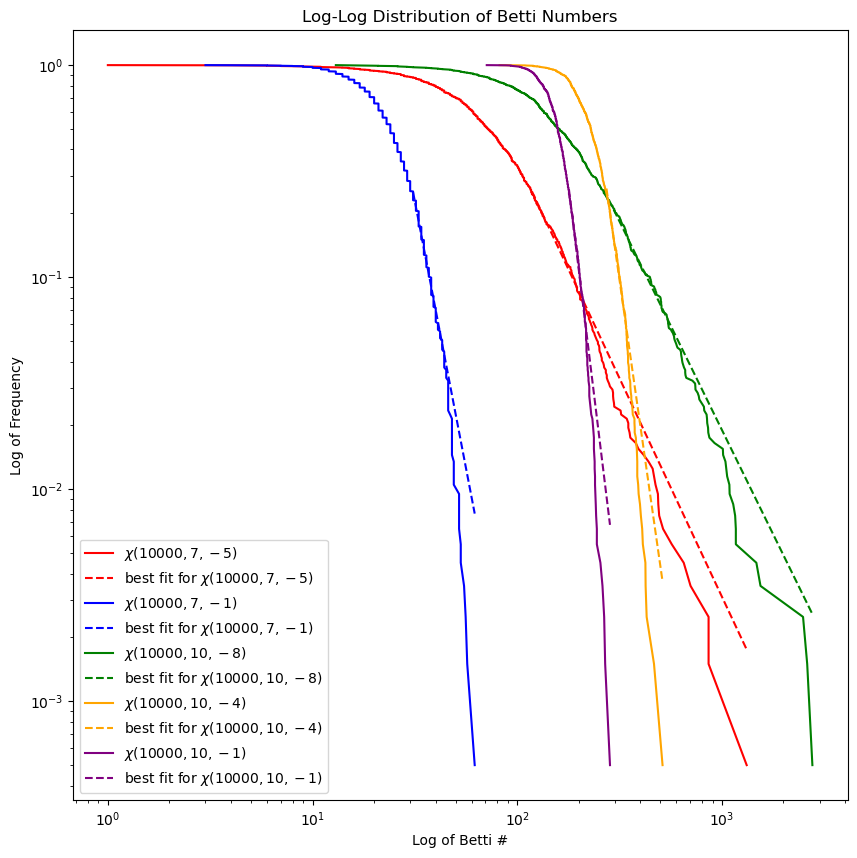

In [73]:
def powerlaw(x, a, b):
    return a * x**b

curve = powerlaw
cols = list(curve.__code__.co_varnames)[1:]
df = pd.DataFrame(columns = cols)

plt.figure(figsize=(10, 10))

threshold = 750 # fit line to data after this point

for i in range(len(x)):
    plt.plot(x[i], cdf[i], color = colors[i], label = f'$\chi{args[i]}$')
    popt, _ = curve_fit(curve, x[i][threshold:], cdf[i][threshold:], maxfev = 10000)
    data = {cols[i] : popt[i] for i in range(len(popt))}
    data.update({'num nodes' : args[i][0], 'm' : args[i][1], 'delta' : args[i][2]})
    data['color'] = colors[i]
    df = pd.concat([df, pd.DataFrame([data])], ignore_index = True)
    plt.plot(x[i][threshold:], curve(x[i][threshold:], *popt), '--', color = colors[i], label = f'best fit for $\chi{args[i]}$')
#     a, b = np.polyfit(xlog[i], cdflog[i], 1)
#     plt.plot(x[i], a * x[i] + b, linestyle='--', linewidth=2, label = f'Best fit for $\chi{args[i]}$')
    
plt.xlabel('Log of Betti #')
plt.ylabel('Log of Frequency')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'Log-Log Distribution of Betti Numbers')
plt.show()


In [71]:
df

,a,b,num nodes,m,delta,color
0,4.685426e+03,-2.059094,10000.0,7.0,-5.0,red
1,8.114158e+06,-5.034775,10000.0,7.0,-1.0,blue
2,1.493942e+04,-1.964829,10000.0,10.0,-8.0,green
3,7.753850e+15,-6.761418,10000.0,10.0,-4.0,orange
4,1.518145e+17,-7.887044,10000.0,10.0,-1.0,purple
